# Basics of Word Vectors

```{index} Word vectors ; basics
```

Word vectors are a mainstay of NLP, and are used in a variety of tasks, from sentiment analysis to machine translation. In this experiment, we will explore the very basics of word vectors, and how they can be used to represent words in a way that captures their meaning. Word vector models represent words as vectors in a high-dimensional space, where the distance between vectors captures the similarity and relationships between words within a given context of a corpus.

For the purposes of simplicity, we will use the `gensim` library and a ready made word vector model. The model we will use is the `glove-wiki-gigaword-50` model, which is a 50-dimensional word vector model trained on the Wikipedia corpus.

Let's start by loading the model.

In [24]:
import os
import sys
import contextlib
import gensim.downloader as api

# Define a context manager to suppress stdout and stderr
@contextlib.contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Use the context manager to suppress output from the model download
with suppress_stdout_stderr():
    model = api.load("glove-wiki-gigaword-50")
print(model)

KeyedVectors<vector_size=50, 400000 keys>


## Using word vectors for question answering

```{index} Word vectors ; question answering
```

We will use this model to explore the relationships between words. Let us start with a simple problem - "Brasil is to Portugal, what _X_ is to Spain". We will use word vectors to estimate possible candidates to _X_.

In [25]:
# Calculate the "br - pt + es" vector and find the closest word
result = model.most_similar(positive=['brazil', 'spain'], negative=['portugal'], topn=1)
print(result)
result_word = result[0][0]
# Print the shape of the result vector
dimensions = model[result[0][0]].shape[0]
print("Number of vector dimensions: ", dimensions)

[('mexico', 0.8388405442237854)]
Number of vector dimensions:  50


Great! We now have a candidate word for _X_ and a probability score, also notice how the resulting word vector returned by the model has 50 dimensions.

In [26]:
print(model[result[0][0]])

[ 4.1189e-01 -9.3082e-02 -1.8871e-01  1.0692e+00 -5.3433e-01 -9.9734e-01
 -5.5511e-01  3.2821e-01  1.3527e-01  5.6191e-01  4.1530e-01 -7.6649e-01
  6.4603e-01 -1.8546e-01  7.8123e-01 -8.9799e-01 -4.9891e-01 -2.2080e-01
 -1.3527e-01  1.8387e-01 -7.1566e-01 -7.6888e-01 -8.0441e-02  4.9022e-04
 -5.2532e-01 -1.8385e+00  1.7512e-01  3.3196e-01  2.4221e-01 -5.6305e-01
  2.6126e+00 -2.3889e-03 -5.4640e-01 -7.3415e-01 -4.6359e-01 -7.5214e-01
 -1.2924e+00  2.6360e-01  2.8462e-01  2.6416e-02 -1.0242e+00  5.7252e-01
  1.4757e+00 -1.2457e+00 -6.2902e-01  4.0549e-01 -4.1026e-01 -6.0271e-01
  1.3786e-01 -7.9502e-02]


These numbers encode a lot of meaning regarding the word 'mexico', and in general, the more dimensions present in a given word vector model the more semantic information can be represented by the model!

## Visualising word vectors

```{index} Word vectors ; visualisation
```

Now let us attempt to visualise the relationships between these vector representations - we will perform a comparison between an actual vector operation, and the estimate returned by `gensim` using the `most_similar` operation. We first need to get vector representations for all the words ("portugal", "brazil", "spain" and "mexico") so we can plot their proximity.

In [27]:
import numpy as np

# Calculate the "brazil + spain - portugal" vector
true_vector = model['brazil'] + model['spain'] - model['portugal']

words = ['portugal', 'spain', 'brazil', result_word]

# Get vectors for each word
vectors = np.array([model[w] for w in words])
vectors = np.vstack([vectors, true_vector])  # Add the true vector to the list of vectors
words += ['brazil + spain - portugal']  # Add the label for the true vector

Now, how do we visualize 50 dimensions? We'll need to reduce the dimensionality of our vector space to something manageable! 

```{note}
In this case, we will use Principal Component Analysis (PCA), a statistical procedure that utilizes orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. A better approach would be using t-SNE, but given we have a tiny number of samples, it makes little or no difference.
```

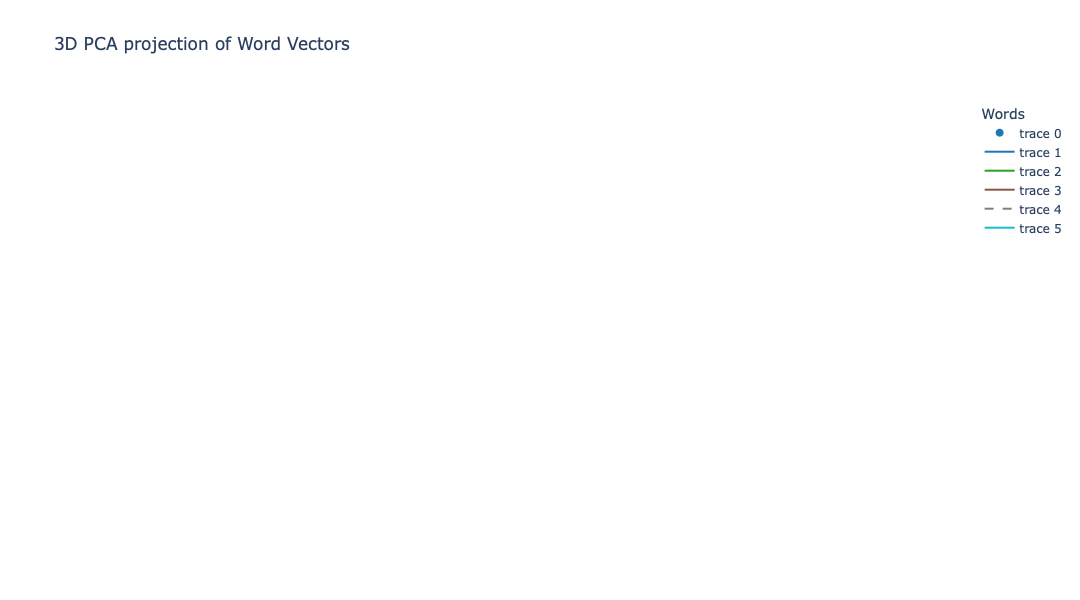

In [28]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(vectors)

# Generate a color map similar to matplotlib's tab10
colors = [f'rgba({r},{g},{b},{a})' for r, g, b, a in plt.cm.tab10(np.linspace(0, 1, len(words)))]

# Create a 3D scatter plot
fig = go.Figure()

# Add scatter plot
fig.add_trace(go.Scatter3d(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1], z=reduced_vectors[:, 2],
                           mode='markers+text', text=words, marker=dict(color=colors), textposition="top center"))

# Optionally add lines from origin to each point if you need to mimic the quiver plot
# This is a bit more involved in Plotly, as you'll have to add a line for each point manually
for i, word in enumerate(words):
    linestyle = 'dash' if word == 'mexico' else 'solid'
    fig.add_trace(go.Scatter3d(x=[0, reduced_vectors[i, 0]], y=[0, reduced_vectors[i, 1]], z=[0, reduced_vectors[i, 2]],
                               mode='lines', line=dict(color=colors[i], dash=linestyle)))

# Set titles and labels
fig.update_layout(scene=dict(xaxis_title='X Axis', yaxis_title='Y Axis', zaxis_title='Z Axis'),
                  legend_title="Words", title="3D PCA projection of Word Vectors", height=600)

fig.show()

Notice how the "true" vector (the 'brazil + spain - portugal' edge) doesn't seem to align much or be anywhere near "mexico" ? This can simply be explained by dimensionality reduction - the original number of dimensions is much higher than three, and our dimenionality reduction does not capture the complexity of the data. Take the above as a mere ilustration.

Now to offer a different visualisation, let us perform an interactive 3D plot of a variety of countries using Plotly.

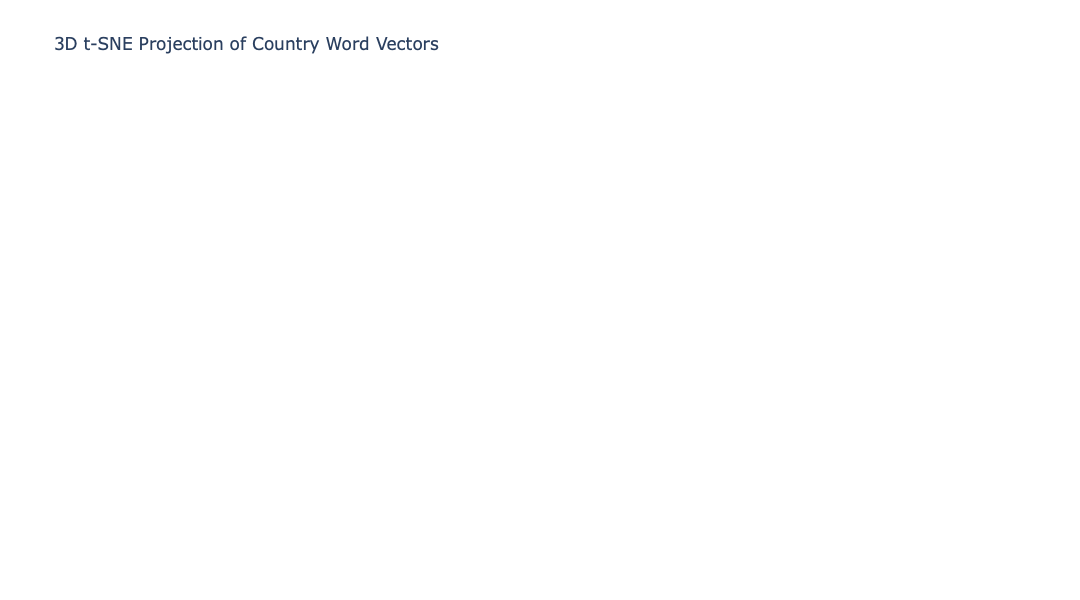

In [29]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go

countries = ['afghanistan', 'albania', 'algeria', 'andorra', 'angola', 'argentina', 'armenia', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bhutan', 'bolivia', 'botswana', 'brazil', 'brunei', 'bulgaria', 'burundi', 'cambodia', 'cameroon', 'canada', 'chad', 'chile', 'china', 'colombia', 'comoros', 'croatia', 'cuba', 'cyprus', 'denmark', 'djibouti', 'dominica', 'ecuador', 'egypt', 'eritrea', 'estonia', 'ethiopia', 'fiji', 'finland', 'france', 'gabon', 'gambia', 'georgia', 'germany', 'ghana', 'greece', 'grenada', 'guatemala', 'guinea', 'guinea-bissau', 'guyana', 'haiti', 'honduras', 'hungary', 'iceland', 'india', 'indonesia', 'iran', 'iraq', 'ireland', 'israel', 'italy', 'jamaica', 'japan', 'jordan', 'kazakhstan', 'kenya', 'kiribati', 'kuwait', 'kyrgyzstan', 'laos', 'latvia', 'lebanon', 'lesotho', 'liberia', 'libya', 'liechtenstein', 'lithuania', 'luxembourg', 'madagascar', 'malawi', 'malaysia', 'maldives', 'mali', 'malta', 'mauritania', 'mauritius', 'mexico', 'micronesia', 'moldova', 'monaco', 'mongolia', 'montenegro', 'morocco', 'mozambique', 'myanmar', 'namibia', 'nauru', 'nepal', 'netherlands', 'nicaragua', 'niger', 'nigeria', 'norway', 'oman', 'pakistan', 'palau', 'panama', 'paraguay', 'peru', 'philippines', 'poland', 'portugal', 'qatar', 'romania', 'russia', 'rwanda', 'samoa', 'senegal', 'serbia', 'seychelles', 'singapore', 'slovakia', 'slovenia', 'somalia', 'spain', 'sudan', 'suriname', 'sweden', 'switzerland', 'syria', 'tajikistan', 'tanzania', 'thailand', 'timor-leste', 'togo', 'tonga', 'tunisia', 'turkey', 'turkmenistan', 'tuvalu', 'uganda', 'ukraine', 'uruguay', 'uzbekistan', 'vanuatu', 'venezuela', 'vietnam', 'yemen', 'zambia', 'zimbabwe']

vectors = np.array([model[country] for country in countries])

# Perform t-SNE to reduce to 3 dimensions
tsne = TSNE(n_components=3, random_state=42)  # Setting a random_state for reproducibility
reduced_vectors = tsne.fit_transform(vectors)

# Plotting the 3D projection

xs = reduced_vectors[:,0]
ys = reduced_vectors[:,1]
zs = reduced_vectors[:,2]

# Create a 3D scatter plot using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    text=countries,  # Use country names as hover text
    mode='markers+text',  # Combine markers and text
    marker=dict(
        size=5,  # Marker size
        color=zs,  # Color markers by their z-values for depth effect
        colorscale='Viridis',  # Choose a color scale
        opacity=0.8  # Marker opacity
    ),
    textposition='top center'  # Position the text above the markers
)])

# Update layout for a cleaner look
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title="3D t-SNE Projection of Country Word Vectors",
    legend_title="Countries",
    height=600
)

# Show plot
fig.show()

## Answering further questions

Finally let us investigate a few more questions to see what the model returns.

In [30]:
# Codfish is to Portugal as ? is to Spain
result = model.most_similar(positive=['spain', 'codfish'], negative=['portugal'], topn=1)
print(result)

# Barcelona is to Spain as ? is to Portugal
result = model.most_similar(positive=['portugal', 'barcelona'], negative=['spain'], topn=1)
print(result)

# Lisbon is to Portugal as ? is to Britain
result = model.most_similar(positive=['britain', 'lisbon'], negative=['portugal'], topn=1)
print(result)


[('fritters', 0.6981064677238464)]
[('porto', 0.8763006925582886)]
[('london', 0.7939332127571106)]


## Final remarks

Word vectors are a powerful tool in NLP, and can be used to capture the meaning of words in a high-dimensional space. They can be used to estimate relationships between words, and can be used in a variety of tasks, from sentiment analysis to machine translation. In this experiment, we used the `gensim` library and a pre-trained word vector model to estimate relationships between words, and explored the use of word vectors in a simple question answering task.